In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gneiss.sort import niche_sort, mean_niche_estimator
import seaborn as sns
from matplotlib import cm

from scipy.stats import skew
import scipy.sparse
%matplotlib inline

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Let's first add some code used to simulate band tables

In [2]:
def shift(l,n):
    sl = l
    table = [l]
    if n == 0:
        return table
    else:
        for k in range(n):
            sl = shift1(sl)
            table.append(sl)
        return table
def shift1(l):
    newlist = [0] * len(l)
    for i in range(1,len(l)):
        newlist[i] = l[i-1]
    return newlist    

Now, let's create a statistic to measure the strength of a band pattern.

Here, we will simplify measure the distance of a cell away from the diagonal, and weight that distance 
by the value in that cell.

In [3]:
def band_statistic(table):
    n, m = table.shape
    sse = 0
    for x in range(table.shape[0]):
        for y in range(table.shape[1]):
            sse += ((y - (n/m) * x) * table[x, y]) **2
    return sse

TODO: Try out the Pearson correlation

In [4]:
#def pearson_correlation(table, gradient):
#    mean_g = mean_niche_estimator(table, gradient)
#    gradient
    

Let's create a really small table for demonstration.

In [5]:
n = 30  #otus 
band = 10 #band size
p = n - band + 1 #samples
y = [1./band]*band + [0]*(n-band)
table = shift(y,p-1)
table = np.column_stack(table)

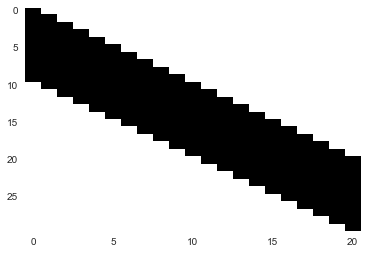

In [6]:
plt.imshow(table, aspect='auto', interpolation='nearest')
plt.grid(False)

In [7]:
band_statistic(table)

290.57142857142878

In [8]:
table_df = pd.DataFrame(table)
gradient_s = pd.Series(range(table.shape[0]))

In [9]:
band_statistic(niche_sort(table_df, gradient_s).values)

290.57142857142878

Ok, let's try to see what this will look like for random data.

In [10]:
random_table = pd.DataFrame(np.random.uniform(low=0.0, high=2.0, size=table.shape))
random_ph = pd.Series(np.random.uniform(low=0.0, high=1.0, size=table.shape[1]))
random_sorted_table = niche_sort(random_table, random_ph)

In [11]:
random_table.shape

(30, 21)

In [12]:
mean_ph = mean_niche_estimator(random_table.T, random_ph)

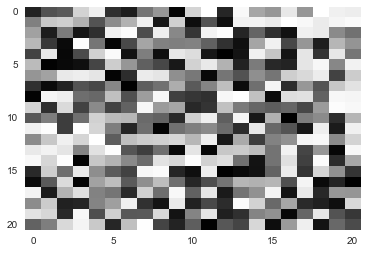

In [13]:
plt.imshow(random_sorted_table, aspect='auto', interpolation='nearest')
plt.grid(False)

In [14]:
band_statistic(random_table.values)

269821.41593373776

Ok, so it looks like our simple statistic isn't complete crap.
Let's now try to formalize a permutation test.

Here, we will randomly permute values along the gradient, and `niche_sort` the table
according to values in this gradient.  We'll use the band statistic applied to these
scrambed/resorted tables to see how reliable the original statistic is.

In [15]:
"""
Only permutes the pH
"""
def band_permutation_test1(table:pd.DataFrame, gradient: pd.Series, 
                           permutations: int=999):
    _table = niche_sort(table, gradient)
    sse = band_statistic(_table.values)
    
    sse_stats = np.zeros(permutations)
    for p in range(permutations):
        _gradient = pd.Series(np.random.permutation(gradient_s),
                              index=gradient_s.index)
        _table = niche_sort(table, _gradient)
        sse_ = band_statistic(_table.values)
        sse_stats[p] = sse_
    pvalue = ((sse >= sse_stats).sum() + 1) / (permutations + 1)
    return sse, pvalue, sse_stats

In [16]:
table_df = pd.DataFrame(table)
gradient_s = pd.Series(range(table.shape[0]))

In [17]:
stat, pval, rstats = band_permutation_test1(table_df, gradient_s)

In [18]:
stat, pval

(290.57142857142878, 0.001)

Ok, what does the distribution of permuted band statistics look like?

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


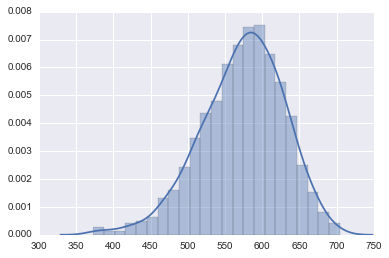

In [19]:
sns.distplot(rstats)

In [20]:
print('mean', rstats.mean())
print('variance', rstats.var())
print('skew', skew(rstats))

mean 573.09125452
variance 3085.49792284
skew -0.49195232633788555


It doesn't look normal.  Definitely is skewed towards the right.

But rather than permutating the labels of the gradient, what if we scramble all of the
values in the table?  We'll use a similar strategy as above.  But rather than
scrambling the gradient values, we'll scramble the table values, and `niche_sort` the table 
with respect to the gradient values.

In [21]:
"""
Completely scrambles elements within the table.
"""
def band_permutation_test2(table:pd.DataFrame, gradient: pd.Series, 
                           permutations: int=999):
    _table = niche_sort(table, gradient)
    sse = band_statistic(_table.values)
    
    sse_stats = np.zeros(permutations)
    for p in range(permutations):
        vals = np.random.permutation(table.values.flatten())
        _table = pd.DataFrame(vals.reshape(table.shape[0], table.shape[1]),
                              index=table.index, columns=table.columns)    
        _table = niche_sort(_table, gradient)
        sse_ = band_statistic(_table.values)
        sse_stats[p] = sse_
    pvalue = ((sse >= sse_stats).sum() + 1) / (permutations + 1)
    return sse, pvalue, sse_stats

In [22]:
stat, pval, rstats = band_permutation_test2(table_df, gradient_s)

In [23]:
stat, pval

(290.57142857142878, 0.001)

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


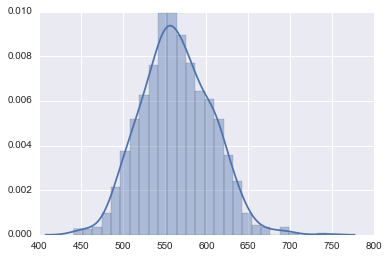

In [24]:
sns.distplot(rstats)

In [25]:
print('mean', rstats.mean())
print('variance', rstats.var())
print('skew', skew(rstats))

mean 564.232077792
variance 1751.17992897
skew 0.1993251848759367


Now this statistic seems to be skewed the opposite direction.  While these distributions are a little similar, 
the first distribution has a significantly larger mean than the second distribution.

TODO:
1. Shuffle rows independently
2. Shuffle columns independently

In [26]:
_table = niche_sort(table_df, gradient_s)
sse = band_statistic(_table.values)
_gradient = pd.Series(np.random.permutation(gradient_s),
                      index=gradient_s.index)
_table = niche_sort(table_df, _gradient)

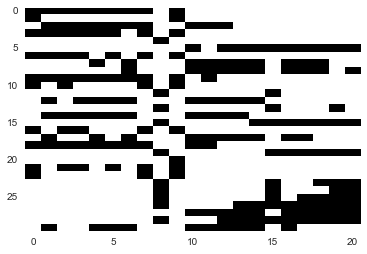

In [27]:
plt.imshow(_table, aspect='auto', interpolation='nearest')
plt.grid(False)

TODO:
- Power analysis?


What if we opt for Pearson correlation instead?

In [28]:
S = scipy.sparse.coo_matrix(table)

In [73]:
def weighted_covariance(table):
    n, m = table.shape
    S = scipy.sparse.coo_matrix(table)
    coords = np.array(list(zip(S.row, S.col, S.data)))
    x, y, w = coords[:, 0], coords[:, 1], coords[:, 2]
    return _weighted_covariance(x, y, w)

def _weighted_covariance(x, y, w):
    mx = x.dot(w) / w.sum()
    my = y.dot(w) / w.sum()
    return w.dot((x-mx) * (y-my)) / w.sum()
    
def weighted_correlation(table):
    n, m = table.shape
    S = scipy.sparse.coo_matrix(table)
    coords = np.array(list(zip(S.row, S.col, S.data)))
    x, y, w = coords[:, 0], coords[:, 1], coords[:, 2]
    cxy = _weighted_covariance(x, y, w)
    cxx = _weighted_covariance(x, x, w)
    cyy = _weighted_covariance(y, y, w)
    return cxy / np.sqrt(cxx * cyy) 

In [84]:
"""
Only permutes the pH
"""
def corr_permutation_test1(table:pd.DataFrame, gradient: pd.Series, 
                          permutations: int=999):
    _table = niche_sort(table, gradient)
    sse = weighted_correlation(_table.values)
    
    sse_stats = np.zeros(permutations)
    for p in range(permutations):
        _gradient = pd.Series(np.random.permutation(gradient_s),
                              index=gradient_s.index)
        _table = niche_sort(table, _gradient)
        sse_ = weighted_correlation(_table.values)
        sse_stats[p] = sse_
    pvalue = ((sse <= sse_stats).sum() + 1) / (permutations + 1)
    return sse, pvalue, sse_stats

In [85]:
table_df = pd.DataFrame(table)
gradient_s = pd.Series(range(table.shape[0]))

In [86]:
stat, pval, rstats = corr_permutation_test1(table_df, gradient_s)

In [87]:
stat

0.90350790290525107

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


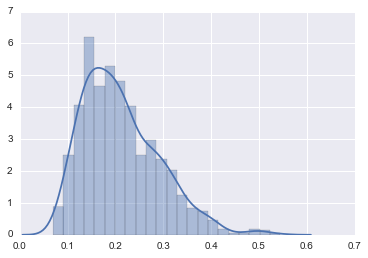

In [89]:
sns.distplot(rstats)

In [92]:
"""
Completely scrambles elements within the table.
"""
def corr_permutation_test2(table:pd.DataFrame, gradient: pd.Series, 
                           permutations: int=999):
    _table = niche_sort(table, gradient)
    sse = weighted_correlation(_table.values)
    
    sse_stats = np.zeros(permutations)
    for p in range(permutations):
        vals = np.random.permutation(table.values.flatten())
        _table = pd.DataFrame(vals.reshape(table.shape[0], table.shape[1]),
                              index=table.index, columns=table.columns)    
        _table = niche_sort(_table, gradient)
        sse_ = weighted_correlation(_table.values)
        sse_stats[p] = sse_
    pvalue = ((sse <= sse_stats).sum() + 1) / (permutations + 1)
    return sse, pvalue, sse_stats

In [93]:
stat, pval, rstats = corr_permutation_test2(table_df, gradient_s)

In [94]:
stat

0.90350790290525107

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


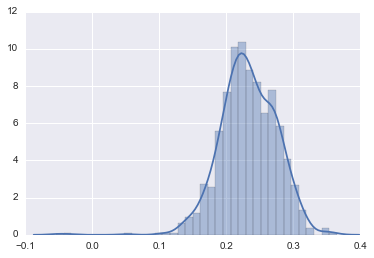

In [95]:
sns.distplot(rstats)

In [101]:
import copy
"""
Scrambles values in table per row
"""
def row_permute(table):
    _table = copy.deepcopy(table)
    for r in table.index:
        _table.loc[r, :] = np.random.permutation(_table.loc[r, :])
    return _table

def corr_permutation_test3(table:pd.DataFrame, gradient: pd.Series, 
                           permutations: int=999):
    _table = niche_sort(table, gradient)
    sse = weighted_correlation(_table.values)
    
    sse_stats = np.zeros(permutations)
    for p in range(permutations):
        _table = row_permute(table)
        _table = niche_sort(_table, gradient)
        sse_ = weighted_correlation(_table.values)
        sse_stats[p] = sse_
    pvalue = ((sse <= sse_stats).sum() + 1) / (permutations + 1)
    return sse, pvalue, sse_stats

In [102]:
stat, pval, rstats = corr_permutation_test3(table_df, gradient_s)

In [103]:
stat

0.90350790290525107

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


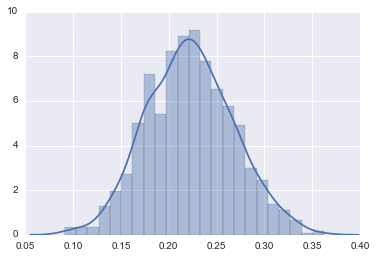

In [104]:
sns.distplot(rstats)

In [105]:
import copy
"""
Scrambles values in table per column
"""
def col_permute(table):
    _table = copy.deepcopy(table)
    for r in table.columns:
        _table.loc[:, c] = np.random.permutation(_table.loc[:, c])
    return _table

def corr_permutation_test4(table:pd.DataFrame, gradient: pd.Series, 
                           permutations: int=999):
    _table = niche_sort(table, gradient)
    sse = weighted_correlation(_table.values)
    
    sse_stats = np.zeros(permutations)
    for p in range(permutations):
        _table = col_permute(table)
        _table = niche_sort(_table, gradient)
        sse_ = weighted_correlation(_table.values)
        sse_stats[p] = sse_
    pvalue = ((sse <= sse_stats).sum() + 1) / (permutations + 1)
    return sse, pvalue, sse_stats

In [106]:
stat, pval, rstats = corr_permutation_test3(table_df, gradient_s)

In [107]:
stat

0.90350790290525107

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


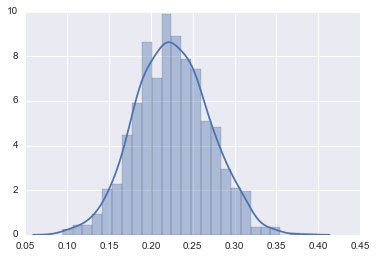

In [108]:
sns.distplot(rstats)